## This notebook answers the Question 4 - Can a predictive model be built for future prediction of the possibility of complaints of the specific type that you identified in response to Question 1?

### I will perform time series analysis to predict the number of complaints in the future complaints. In this analysis I think the NYC 311 data is sufficient to start with. Infact, the pluto dataset has static features that do not have dynamic dependence on time. For this reason, I focus only on NYC 311 comaplint dataset. However, one can import weather data for the given time interval (2010-2018) as it may help in deciding the HEATING complaints.

## Here I will use 'Time Series Forecasting with ARIMA' to predict the number of complaints in the future 

In [1]:
!pip install --upgrade pip


Requirement already up-to-date: pip in /Applications/anaconda/lib/python3.5/site-packages (19.1.1)


In [2]:
!pip install missingno


In [3]:
import pandas as pd
import numpy as np
import scipy
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import statsmodels.api as sm
import itertools
import warnings
from pylab import rcParams


%matplotlib inline

pd.options.display.float_format = '{:20,.3f}'.format
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 1000
np.set_printoptions(precision=3)

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

## Read Data

In [4]:
# Create a Dataframe out of the file:

df_complaint = pd.read_csv('./data/NYCdata.csv')

In [5]:
# combine HEAT/HOT WATER complaint to HEATING complaint as after 2014 it is same

df_complaint['complaint_type'] = np.where(df_complaint['complaint_type']=='HEATING','HEAT/HOT WATER',df_complaint['complaint_type'])

In [6]:
df_complaint['complaint_type'].value_counts()


HEAT/HOT WATER            2018196
PLUMBING                   689776
GENERAL CONSTRUCTION       500863
UNSANITARY CONDITION       412845
PAINT - PLASTER            361258
PAINT/PLASTER              328209
ELECTRIC                   296711
NONCONST                   260890
DOOR/WINDOW                191240
WATER LEAK                 178419
GENERAL                    139492
FLOORING/STAIRS            129930
APPLIANCE                  105757
HPD Literature Request      53563
SAFETY                      47262
OUTSIDE BUILDING             6804
ELEVATOR                     5966
CONSTRUCTION                 5078
STRUCTURAL                     16
AGENCY                          9
VACANT APARTMENT                8
Name: complaint_type, dtype: int64

In [7]:
df_complaint.head(5)


,address_type,borough,city,closed_date,complaint_type,created_date,incident_address,incident_zip,latitude,location_type,longitude,resolution_description,status,street_name,unique_key
0,NaN,Unspecified,NaN,2013-01-11T15:01:56.000,HPD Literature Request,2013-01-11T13:25:34.000,NaN,nan,nan,NaN,nan,"The literature has been mailed. If it has not been received, please request it again from 311.",Closed,NaN,24765056
1,ADDRESS,QUEENS,Queens Village,2019-03-30T08:58:02.000,PAINT/PLASTER,2018-08-11T19:19:41.000,104-34 219 STREET,"11,429.000",40.712,RESIDENTIAL BUILDING,-73.736,The Department of Housing Preservation and Development inspected the following conditions. No violations were issued. The complaint has been closed.,Closed,219 STREET,39981834
2,ADDRESS,QUEENS,Queens Village,2019-03-30T08:58:01.000,APPLIANCE,2018-08-11T19:19:41.000,104-34 219 STREET,"11,429.000",40.712,RESIDENTIAL BUILDING,-73.736,The Department of Housing Preservation and Development inspected the following conditions. No violations were issued. The complaint has been closed.,Closed,219 STREET,39982698
3,ADDRESS,QUEENS,Queens Village,2019-03-30T08:58:01.000,UNSANITARY CONDITION,2018-08-11T19:19:41.000,104-34 219 STREET,"11,429.000",40.712,RESIDENTIAL BUILDING,-73.736,The Department of Housing Preservation and Development inspected the following conditions. Violations were issued. Information about specific violations is available at www.nyc.gov/hpd.,Closed,219 STREET,39987943
4,ADDRESS,QUEENS,Saint Albans,2019-03-30T08:58:02.000,DOOR/WINDOW,2018-10-23T19:27:06.000,116-35 195 STREET,"11,412.000",40.694,RESIDENTIAL BUILDING,-73.757,The Department of Housing Preservation and Development inspected the following conditions. No violations were issued. The complaint has been closed.,Closed,195 STREET,40636028


In [8]:
# change the 'created_date' object to datetime format
df_complaint['created_date'] =  pd.to_datetime(df_complaint['created_date'])


In [9]:
df_complaint.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5732292 entries, 0 to 5732291
Data columns (total 15 columns):
address_type              object
borough                   object
city                      object
closed_date               object
complaint_type            object
created_date              datetime64[ns]
incident_address          object
incident_zip              float64
latitude                  float64
location_type             object
longitude                 float64
resolution_description    object
status                    object
street_name               object
unique_key                int64
dtypes: datetime64[ns](1), float64(3), int64(1), object(10)
memory usage: 656.0+ MB


In [10]:
# keep the column related to 'created_date' and their unique ID 'unique_key'. In my view, other features are not important as they are not 
# dependent on time

cols = ['address_type', 'borough', 'city', 'closed_date', 'complaint_type',
        'incident_address', 'incident_zip', 'latitude', 'location_type', 'longitude', 'resolution_description', 
        'status','street_name']
df_complaint_ts = df_complaint.drop(cols, axis = 1)
df_complaint_ts.columns

Index(['created_date', 'unique_key'], dtype='object')

In [11]:
df_complaint_ts.head()

,created_date,unique_key
0,2013-01-11 13:25:34,24765056
1,2018-08-11 19:19:41,39981834
2,2018-08-11 19:19:41,39982698
3,2018-08-11 19:19:41,39987943
4,2018-10-23 19:27:06,40636028


In [12]:
df_complaint_ts['date'] = df_complaint_ts['created_date'].map(lambda x: x.strftime('%Y-%m'))


In [13]:
df_complaint_ts['created_year'] = df_complaint_ts['created_date'].map(lambda x: x.strftime('%Y')).astype(int)

In [14]:
df_complaint_ts.head()

,created_date,unique_key,date,created_year
0,2013-01-11 13:25:34,24765056,2013-01,2013
1,2018-08-11 19:19:41,39981834,2018-08,2018
2,2018-08-11 19:19:41,39982698,2018-08,2018
3,2018-08-11 19:19:41,39987943,2018-08,2018
4,2018-10-23 19:27:06,40636028,2018-10,2018


In [15]:
# condition to remove year 2019 complaints from the dataset as it is incomplete yet
df_complaint_ts = df_complaint_ts[df_complaint_ts.created_year != 2019]
# keep the coloumn date in a fromat '%Y-%m'
df_complaint_ts = df_complaint_ts.drop(['created_date', 'created_year'], axis =1)
df_complaint_ts = df_complaint_ts.sort_values('date')
df_complaint_ts.head()

,unique_key,date
176129,15811124,2010-01
125126,15657760,2010-01
125125,15657759,2010-01
125124,15657758,2010-01
125123,15657757,2010-01


In [16]:
#  count the no of complaints 
df_complaint_ts = df_complaint_ts.groupby(['date']).count()['unique_key']


In [17]:
df_complaint_ts = pd.DataFrame(df_complaint_ts)
df_complaint_ts  = df_complaint_ts.rename(index=str, columns={"unique_key": "no_of_complaints"})

In [18]:
df_complaint_ts.index

Index(['2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06',
       '2010-07', '2010-08', '2010-09', '2010-10',
       ...
       '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08',
       '2018-09', '2018-10', '2018-11', '2018-12'],
      dtype='object', name='date', length=108)

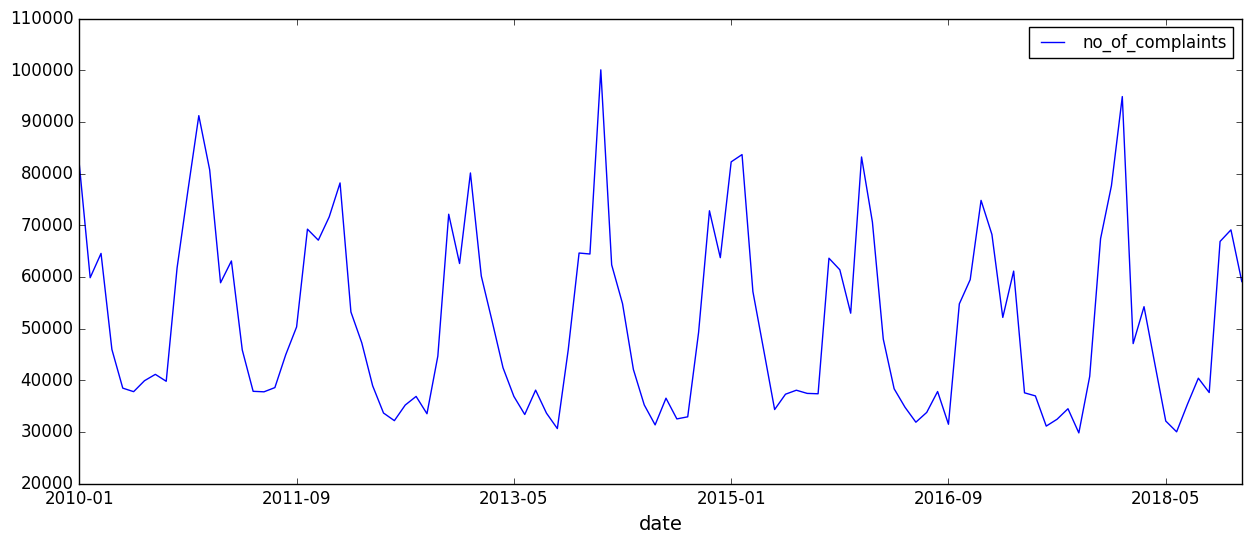

In [19]:
df_complaint_ts.plot(figsize=(15, 6))
plt.show()

In [20]:
df_complaint_ts = df_complaint_ts.reset_index('date')
df_complaint_ts['date'] = pd.to_datetime(df_complaint_ts['date'])
df_complaint_ts = df_complaint_ts.set_index('date')

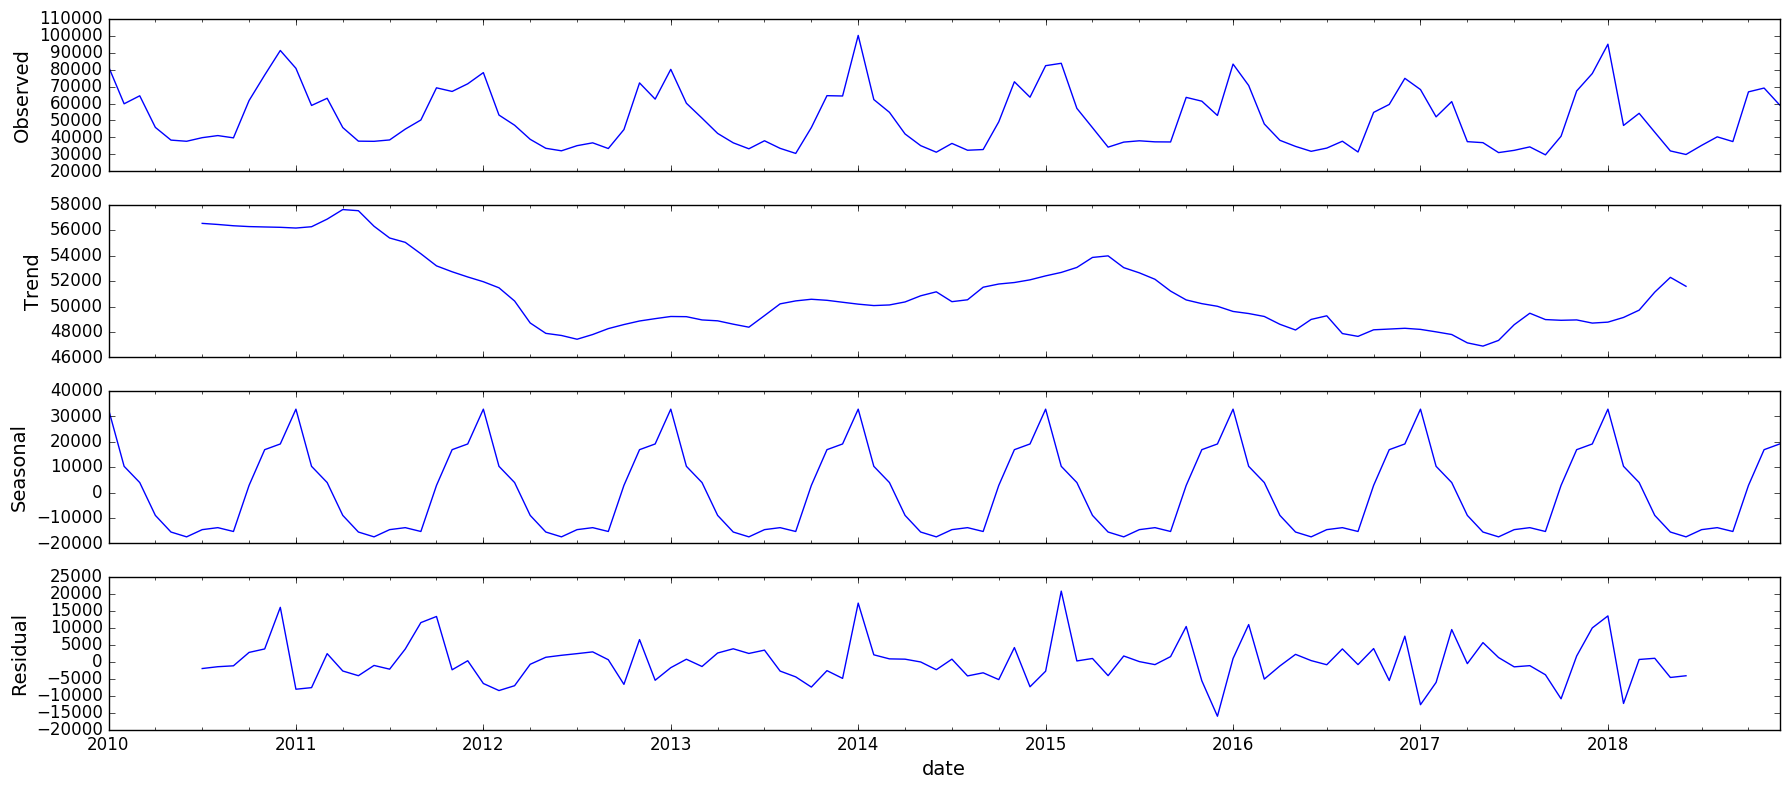

In [21]:
# trend, seasonality, and noise

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_complaint_ts, model='additive')
fig = decomposition.plot()
plt.show()

In [22]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [23]:
#warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_complaint_ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2635.846533502763
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2275.82328857773


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2006.3414634835735
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1730.425439375386
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2025.8640772020433


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2005.3507608288232
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1771.2322493644588


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1731.8429140301846
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2540.2875026183447
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2234.3106263045947


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1986.7464372597706


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1715.324569242954
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2269.2868228978873


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2223.9923071215862
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1771.857817558911


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1716.79753595928
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2325.3623314231622
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2047.6024344654038
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:2037.9041385604737


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1759.3635176633884
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:2044.9152876447438
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:2010.3923667954452


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:1793.0357294494493


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1758.6038714847987
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:2306.2597578028553
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2023.1939192791324


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:1982.0494360689206


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1710.19679930089
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:2039.8714127122787


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1994.808636119948


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:1763.165439070124


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:1712.151317350043
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:2348.326372075887
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:2065.9515976427438


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:2007.0653877265488


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:1735.1420003313033
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:2032.9291874847609


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:2032.6175765244907
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:1751.432777937265


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1736.661757194954
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:2327.516598559753


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2044.1022250109481
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:1988.2151509698604


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:1711.1978063479116


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:2034.4462232913595


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2011.718520071101


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:1754.3308735554385


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1713.1217276339592
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:2327.2508525090357
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:2043.713906951356
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:2024.0827468186214


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:1747.7866907830055
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:2025.8279815877152


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:2018.7890013554052
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:1760.4029900278447


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1749.7172762918801
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:2307.456471025402


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2024.963541039362
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:1983.9144315466358


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1711.7789590849336
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:2018.8103537779673


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1996.773325004654


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:1743.3273441755791


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1713.730167372805


### The above grid search finds the minimum AIC value AIC:1710.19679930089 which corresponds to the parameter ARIMA(0, 1, 1)x(0, 1, 1, 12). So I choose this parameter to build the ARIMA model for future prediction.

In [24]:

mod = sm.tsa.statespace.SARIMAX(df_complaint_ts,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7429      0.082     -9.064      0.000      -0.904      -0.582
ma.S.L12      -0.5185      0.095     -5.463      0.000      -0.705      -0.332
sigma2      1.085e+08   1.66e-10   6.53e+17      0.000    1.08e+08    1.08e+08


/Applications/anaconda/lib/python3.5/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


### Summary statistics shows a very high sigma value which is not correct. Probably one can fix it by taking more parameters into consideration.

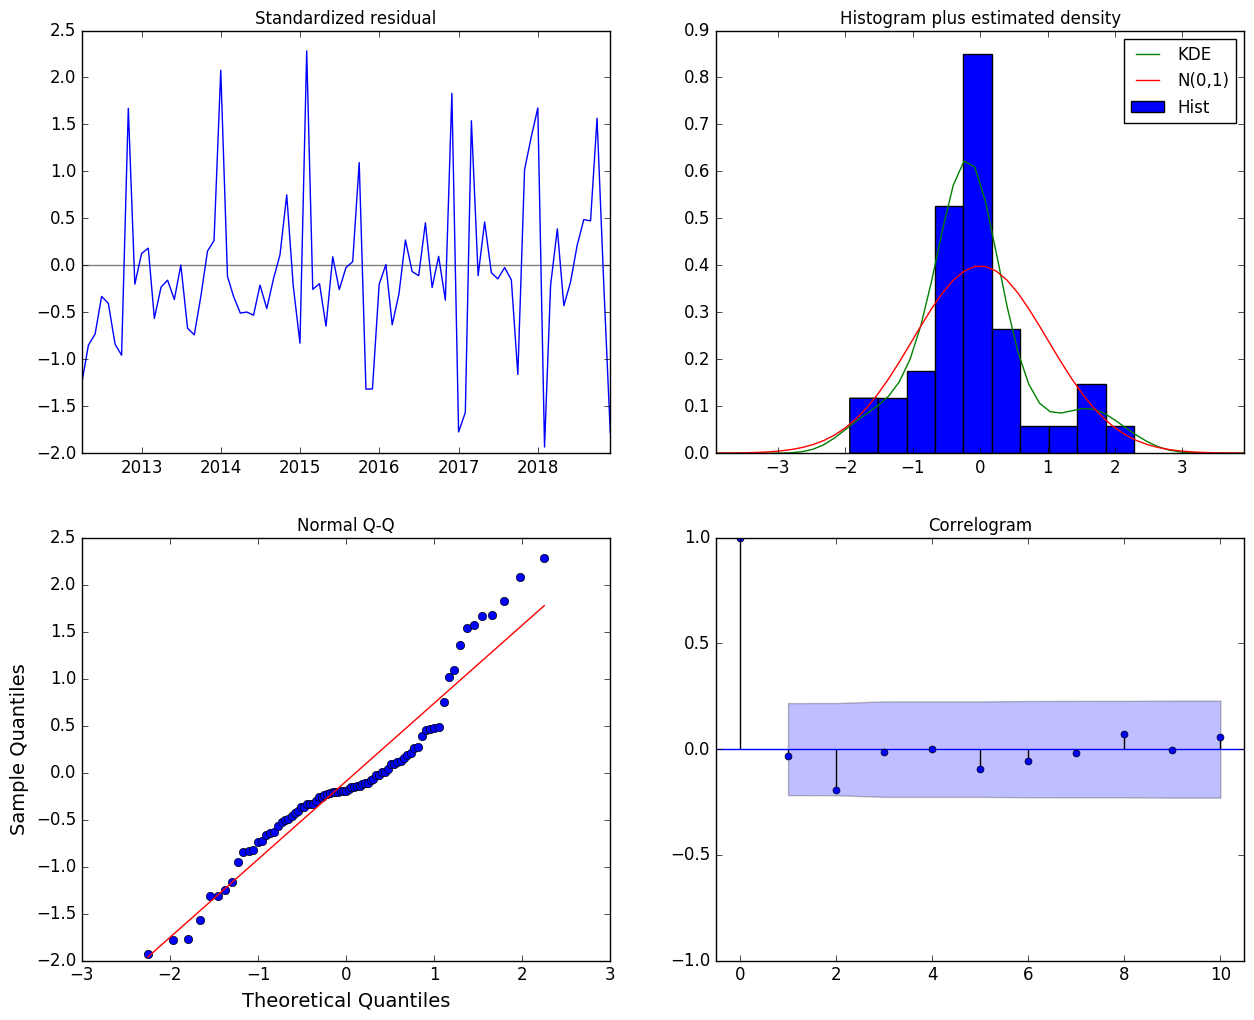

In [25]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()


- In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1. This is a good indication that the residuals are approximatly normally distributed.
- The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

In [26]:
pred = results.get_prediction(start=pd.to_datetime('2018-01'), dynamic=False)
pred_ci = pred.conf_int()

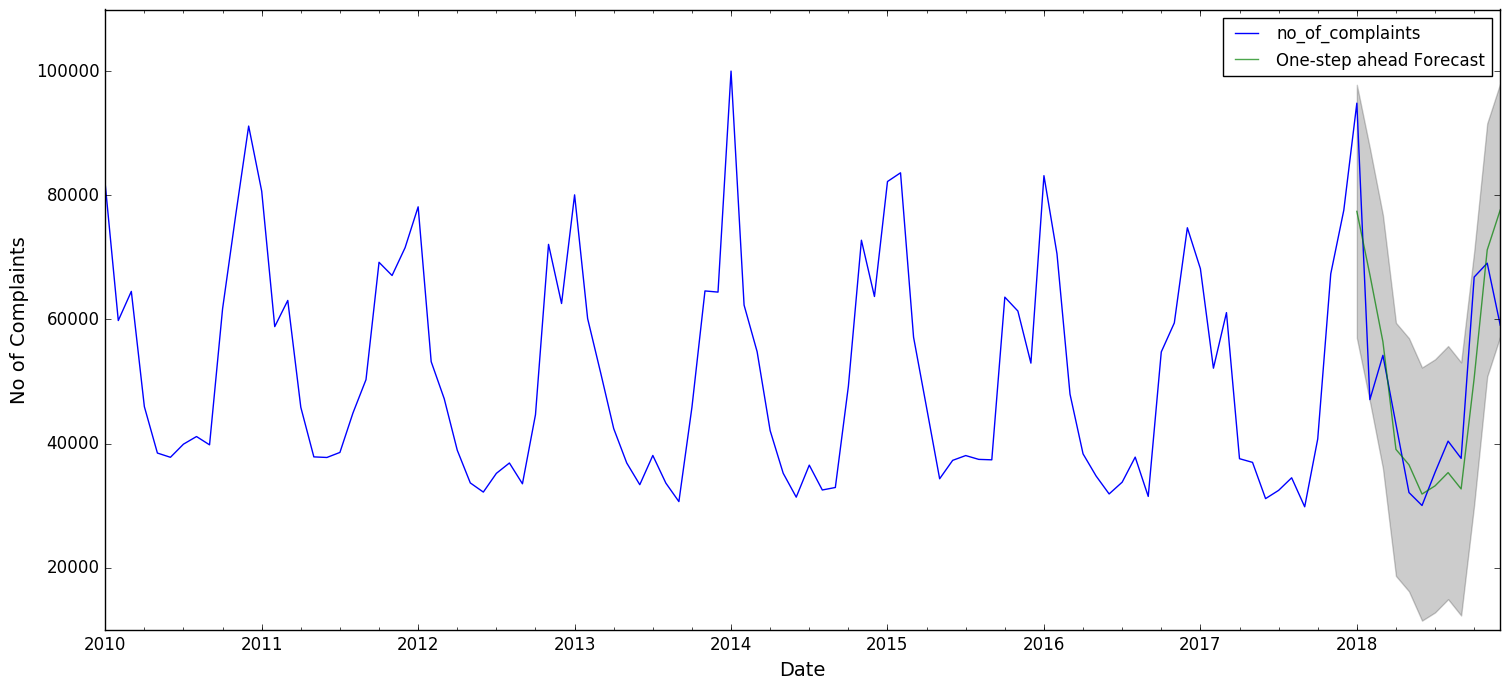

In [27]:
ax = df_complaint_ts['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('No of Complaints')
plt.legend()

plt.show()

### The above one step forcast can be seen to fit well with the actual value, however the confidence interval is large. So we may need to find a better parameters or look at other measures instead of AIC to find the best fits.

In [28]:
y_forecasted = pred.predicted_mean
y_forecasted = pd.DataFrame(y_forecasted)

y_truth = df_complaint_ts['2018-01':]

# Compute the mean square error
mean_absolute_error = abs((y_forecasted[0] - y_truth['no_of_complaints'] ) ** 1).mean()
print('The Mean Absolute Error of our forecasts is {}'.format(round(mean_absolute_error, 2)))



The Mean Absolute Error of our forecasts is 8281.15


In [29]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=20)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

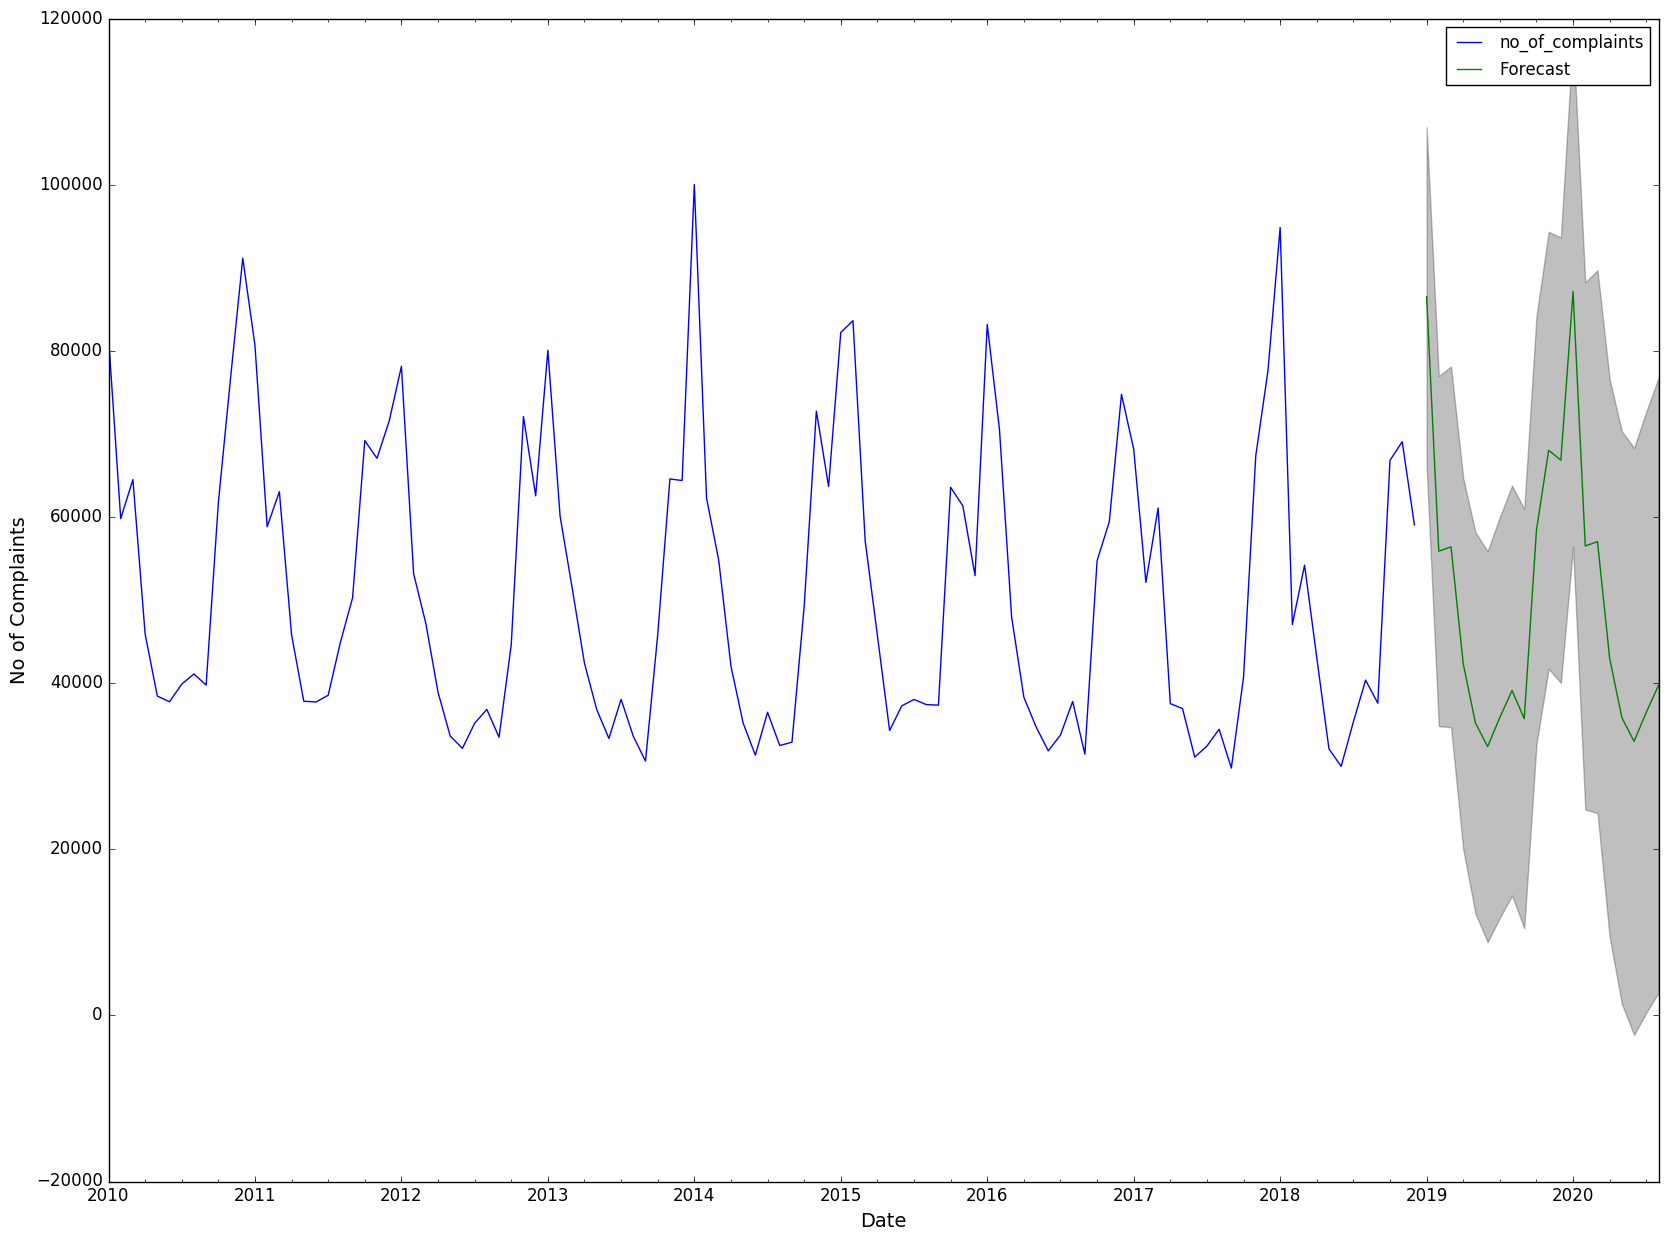

In [30]:
ax = df_complaint_ts.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('No of Complaints')

plt.legend()
plt.show()

# <font color=red> Concluding Remark:
- <font color=red>  The above 'Time Series Forecasting with ARIMA' has potential to predict the future number of complaints. Accuracy of forecast decreases as we try to predict more far into the future as can be seen by increase in the confidence interval. The model has large mean absolute error, so it is not so good and ready to predict the future number of complaints. However, this may help the authorities to better handle the Housing problems and allocate the appropriate resouces after a more careful modelling the problem.
- <font color=red>  The are also other models availble to for such problems such as 'Time Series Forecasting with Prophet'. One can try them and compare the results for more accurate predictions and have more confidence in their venture.